In [20]:
import pandas as pd
import json 
import os 
import sys
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

path = 'data/llama2_7b'
sns.set(style="whitegrid")

In [21]:
import json 
def gcg_results(path): 
    res = []
    with open(os.path.join(path)) as f:
        for line in f:
            res.append(json.loads(line))

    monitor_losses = []
    gcg_losses = []
    early_stop = []
    for r in res:
        monitor_losses.append(r['monitor_losses'])
        gcg_losses.append(r['gcg_losses'])
        early_stop.append(np.any(r['early_stopping']))

    monitor_losses = np.array(monitor_losses)
    gcg_losses = np.array(gcg_losses)
    early_stop = np.array(early_stop)
    res = {
        'monitor_losses': monitor_losses,
        'gcg_losses': gcg_losses,
        'early_stop': early_stop
    }
    return res

def std_err(data): 
    return np.std(data) / np.sqrt(len(data))

### Probe layer sweep

In [22]:
just_hb_8 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr8.json'))
just_hb_16 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr16.json'))
just_hb_24 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr24.json'))
just_hb_30 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr30.json'))

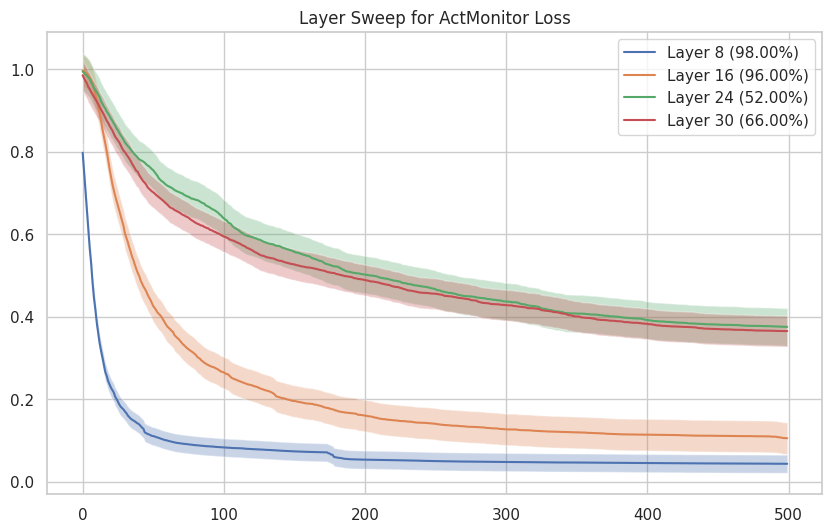

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=just_hb_8['monitor_losses'].mean(0), ax=ax, label=f'Layer 8 ({just_hb_8["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_8['monitor_losses'].mean(0) - std_err(just_hb_8['monitor_losses']), just_hb_8['monitor_losses'].mean(0) + std_err(just_hb_8['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_16['monitor_losses'].mean(0), ax=ax, label=f'Layer 16 ({just_hb_16["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_16['monitor_losses'].mean(0) - std_err(just_hb_16['monitor_losses']), just_hb_16['monitor_losses'].mean(0) + std_err(just_hb_16['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_24['monitor_losses'].mean(0), ax=ax, label=f'Layer 24 ({just_hb_24["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_24['monitor_losses'].mean(0) - std_err(just_hb_24['monitor_losses']), just_hb_24['monitor_losses'].mean(0) + std_err(just_hb_24['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_30['monitor_losses'].mean(0), ax=ax, label=f'Layer 30 ({just_hb_30["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_30['monitor_losses'].mean(0) - std_err(just_hb_30['monitor_losses']), just_hb_30['monitor_losses'].mean(0) + std_err(just_hb_30['monitor_losses']), alpha=0.3)
plt.title('Layer Sweep for ActMonitor Loss')
plt.show()


### GCG against just the monitor

In [41]:
just_ft_hb_alpaca = gcg_results(os.path.join(path, 'actual_final_gcg_just_ft_llamaguard_harmbench_alpaca_.json'))
just_hb_alpaca_lyr24 = gcg_results(os.path.join(path, 'actual_final_gcg_just_hb_lyr24.json'))

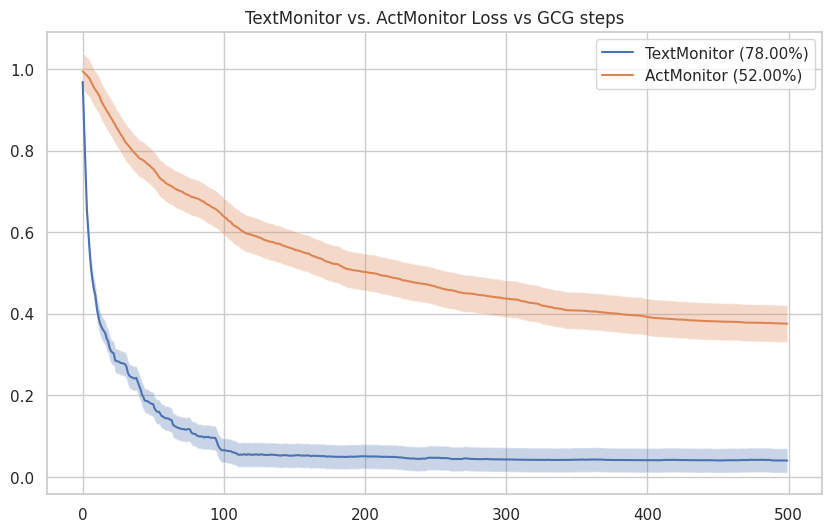

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(data=just_ft_hb_alpaca['monitor_losses'].mean(0), ax=ax, label=f'TextMonitor ({just_ft_hb_alpaca["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_ft_hb_alpaca['monitor_losses'].mean(0) - std_err(just_ft_hb_alpaca['monitor_losses']), just_ft_hb_alpaca['monitor_losses'].mean(0) + std_err(just_ft_hb_alpaca['monitor_losses']), alpha=0.3)
sns.lineplot(data=just_hb_alpaca_lyr24['monitor_losses'].mean(0), ax=ax, label=f'ActMonitor ({just_hb_alpaca_lyr24["early_stop"].mean() * 100:.2f}%)')
plt.fill_between(np.arange(500), just_hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(just_hb_alpaca_lyr24['monitor_losses']), just_hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(just_hb_alpaca_lyr24['monitor_losses']), alpha=0.3)
plt.title('TextMonitor vs. ActMonitor Loss vs GCG steps')
plt.show()

### GCG against both

In [46]:
ft_hb_alpaca = gcg_results(os.path.join(path, 'actual_final_gcg_ft_llamaguard_harmbench_alpaca_.json'))
hb_alpaca_lyr24 = gcg_results(os.path.join(path, 'actual_final_gcg_hb_lyr24.json'))

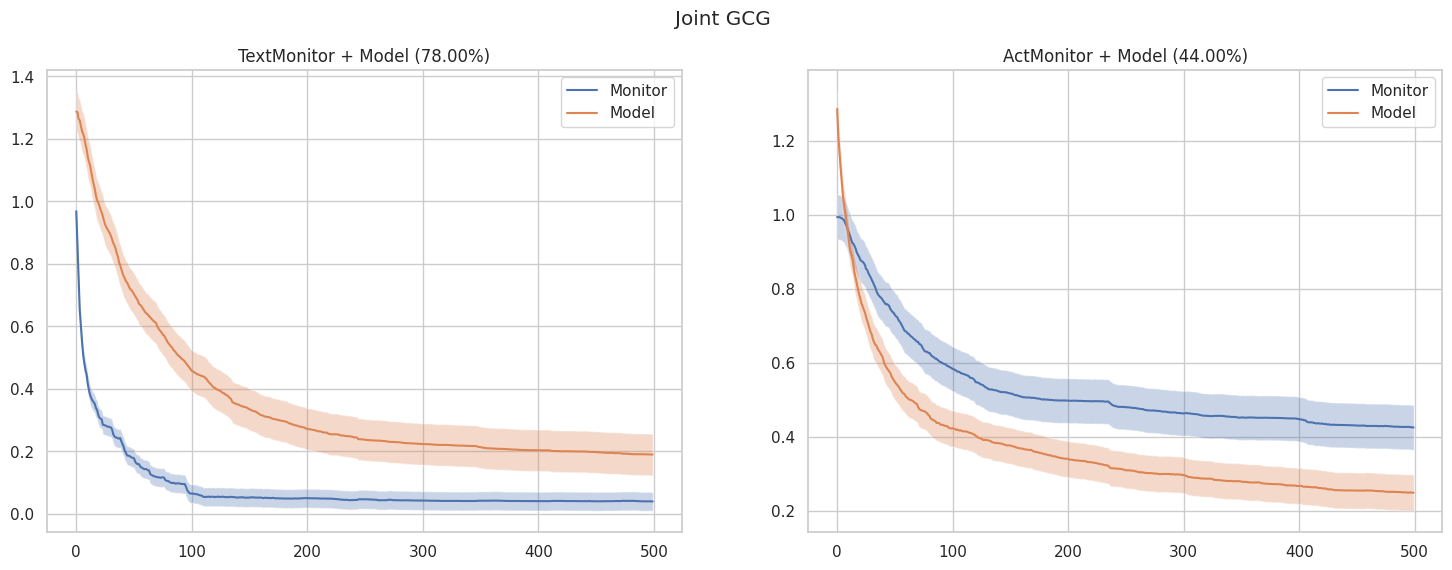

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=ft_hb_alpaca['monitor_losses'].mean(0), ax=axs[0], label='Monitor')
axs[0].fill_between(np.arange(500), ft_hb_alpaca['monitor_losses'].mean(0) - std_err(ft_hb_alpaca['monitor_losses']), ft_hb_alpaca['monitor_losses'].mean(0) + std_err(ft_hb_alpaca['monitor_losses']), alpha=0.3)
sns.lineplot(data=ft_hb_alpaca['gcg_losses'].mean(0), ax=axs[0], label='Model')
axs[0].fill_between(np.arange(500), ft_hb_alpaca['gcg_losses'].mean(0) - std_err(ft_hb_alpaca['gcg_losses']), ft_hb_alpaca['gcg_losses'].mean(0) + std_err(ft_hb_alpaca['gcg_losses']), alpha=0.3)
axs[0].title.set_text(f'TextMonitor + Model ({ft_hb_alpaca["early_stop"].mean() * 100:.2f}%)')

sns.lineplot(data=hb_alpaca_lyr24['monitor_losses'].mean(0), ax=axs[1], label='Monitor')
axs[1].fill_between(np.arange(500), hb_alpaca_lyr24['monitor_losses'].mean(0) - std_err(hb_alpaca_lyr24['monitor_losses']), hb_alpaca_lyr24['monitor_losses'].mean(0) + std_err(hb_alpaca_lyr24['monitor_losses']), alpha=0.3)
sns.lineplot(data=hb_alpaca_lyr24['gcg_losses'].mean(0), ax=axs[1], label='Model')
axs[1].fill_between(np.arange(500), hb_alpaca_lyr24['gcg_losses'].mean(0) - std_err(hb_alpaca_lyr24['gcg_losses']), hb_alpaca_lyr24['gcg_losses'].mean(0) + std_err(hb_alpaca_lyr24['gcg_losses']), alpha=0.3)
axs[1].title.set_text(f'ActMonitor + Model ({hb_alpaca_lyr24["early_stop"].mean() * 100:.2f}%)')

plt.suptitle('Joint GCG')
plt.show()